In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(0)

# Code adapted from "Eye Diagram" by WarrenWeckesser at https://scipy-cookbook.readthedocs.io/items/EyeDiagram.html
def bres_segment_count_slow(x0, y0, x1, y1, grid):
    """Bresenham's algorithm.

    The value of grid[x,y] is incremented for each x,y
    in the line from (x0,y0) up to but not including (x1, y1).
    """

    if np.any(np.isnan([x0,y0,x1,y1])):
        return    

    nrows, ncols = grid.shape

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)

    sx = 0
    if x0 < x1:
        sx = 1
    else:
        sx = -1
    sy = 0
    if y0 < y1:
        sy = 1
    else:
        sy = -1

    err = dx - dy

    while True:
        # Note: this test is moved before setting
        # the value, so we don't set the last point.
        if x0 == x1 and y0 == y1:
            break

        if 0 <= x0 < nrows and 0 <= y0 < ncols:
            grid[int(x0), int(y0)] += 1

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def bres_curve_count_slow(y, x, grid):
    for k in range(x.size - 1):
        x0 = x[k]
        y0 = y[k]
        x1 = x[k+1]
        y1 = y[k+1]
        bres_segment_count_slow(x0, y0, x1, y1, grid)

def linear_scale(x,src_min,src_max,dst_min,dst_max):
    return dst_min+(x-src_min)*(dst_max-dst_min)/(src_max-src_min)

In [2]:
from ds1054z import DS1054Z
import numpy as np
import matplotlib.pyplot as plt
import time

# connect to osciilscope over network and verify connectivity
scope = DS1054Z('192.168.1.252')
print(scope.idn)

# capture data form scope
def cap_plz():
    scope.run()
    time.sleep(1)
    scope.memory_depth = 120e3
    time.sleep(1)
    scope.single()
    time.sleep(2)

    x = scope.waveform_time_values
    y = scope.get_waveform_samples(1,mode='MAX')
    
    return(x,y)

# constants for bit width
# TODO: derive the time constants form the known bitperiod
tmin = -0.00035
tmax = 0.00035
ymin = -2
ymax = 2

#fig, ax = plt.subplots(1)
#ax.plot(x,y)
#plt.show()

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA192409533,00.04.04.SP3


In [3]:
def calcc(x,y,grid,samples):

    # find rising and falling edges
    trigger_val = 0
    y_data = np.array(y)
    x_data = np.array(x)
    rising = np.flatnonzero((y_data[:-1] < trigger_val) & (y_data[1:] >= trigger_val))+1
    falling = np.flatnonzero((y_data[:-1] > trigger_val) & (y_data[1:] <= trigger_val))

    # constant bit period, since I am too lazy to do clock recovery and don't really need it
    bitperiod = 1/2e3
    extra = 50 # extra number of samples to leave on either end of bit period to make a pretty eye digram

    # add positive bits to eye diagram
    for n in range(1,len(rising)-1):
        start = rising[n]
        start_with_ex = start-extra
        stop = falling[int(np.argmax(falling>start))]
        stop_with_ex = stop+extra
        center = int(np.floor((start+stop)/2))

        # compute bit fraction and ensure we have a valid bit and not double crossing of zero
        bit_fraction = (x_data[stop]-x_data[start])/bitperiod
        if bit_fraction < 0.9:
            #print('too short. discarding {:0.3f} bit'.format(bit_fraction))
            pass
        elif bit_fraction > 0.9 and bit_fraction < 1.1:
            td = (((x_data[start_with_ex:stop_with_ex]-x_data[center]- tmin) / (tmax - tmin)) * grid_size).astype(np.int32)
            yd = (((y_data[start_with_ex:stop_with_ex] - ymin) / (ymax - ymin)) * grid_size).astype(np.int32)

            bres_curve_count_slow(td, yd, grid)
            ax.plot(x_data[start_with_ex:stop_with_ex]-x_data[center],y_data[start_with_ex:stop_with_ex])
            samples += 1
        else:
            # TODO: deal with multi bit data. This is critical for real eye diagrams
            #print('too long. discarding {:0.3f} bit'.format(bit_fraction))
            pass

    # TODO: clean this up. This is pretty much a copy+paste of the pos edge section, this could probably be just one clean loop
    # add negative bits to eye diagram
    for n in range(1,len(falling)-1):
        start = falling[n]
        start_with_ex = start-extra
        stop = rising[int(np.argmax(rising>start))]
        stop_with_ex = stop+extra
        center = int(np.floor((start+stop)/2))

        # compute bit fraction and ensure we have a valid bit and not double crossing of zero
        bit_fraction = (x_data[stop]-x_data[start])/bitperiod
        if bit_fraction < 0.9:
            #print('too short. discarding {:0.3f} bit'.format(bit_fraction))
            pass
        elif bit_fraction > 0.9 and bit_fraction < 1.1:
            td = (((x_data[start_with_ex:stop_with_ex]-x_data[center]- tmin) / (tmax - tmin)) * grid_size).astype(np.int32)
            yd = (((y_data[start_with_ex:stop_with_ex] - ymin) / (ymax - ymin)) * grid_size).astype(np.int32)

            bres_curve_count_slow(td, yd, grid)
            ax.plot(x_data[start_with_ex:stop_with_ex]-x_data[center],y_data[start_with_ex:stop_with_ex])
            samples += 1
        else:
            # TODO: deal with multi bit data. This is critical for real eye diagrams
            #print('too long. discarding {:0.3f} bit'.format(bit_fraction))
            pass

    #plt.show()

    print('Number of samples: {}'.format(samples))
       
    return samples

Number of samples: 567
Number of samples: 1121
Number of samples: 1684
Number of samples: 2239
Number of samples: 2808
Number of samples: 3384
Number of samples: 3954
Number of samples: 4512
Number of samples: 5074
Number of samples: 5632
Number of samples: 6176
Number of samples: 6768
Number of samples: 7331
Number of samples: 7896
Number of samples: 8453
Number of samples: 9024
Number of samples: 9582
Number of samples: 10140
Number of samples: 10695
Number of samples: 11229


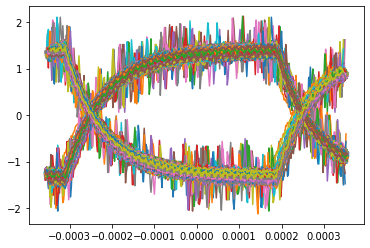

In [4]:
grid_size = 700
grid = np.zeros((grid_size, grid_size), dtype=np.int32)
samples = 0

fig, ax = plt.subplots(1)
# capture data from scope 20 times
for n in range(0,20):
    (x,y) = cap_plz()
    samples = calcc(x,y,grid,samples)
    
plt.show()

In [5]:
def point_to_grid(x,y):
    return (((x - tmin) / (tmax - tmin)) * grid_size, (((y - ymin) / (ymax - ymin)) * grid_size))

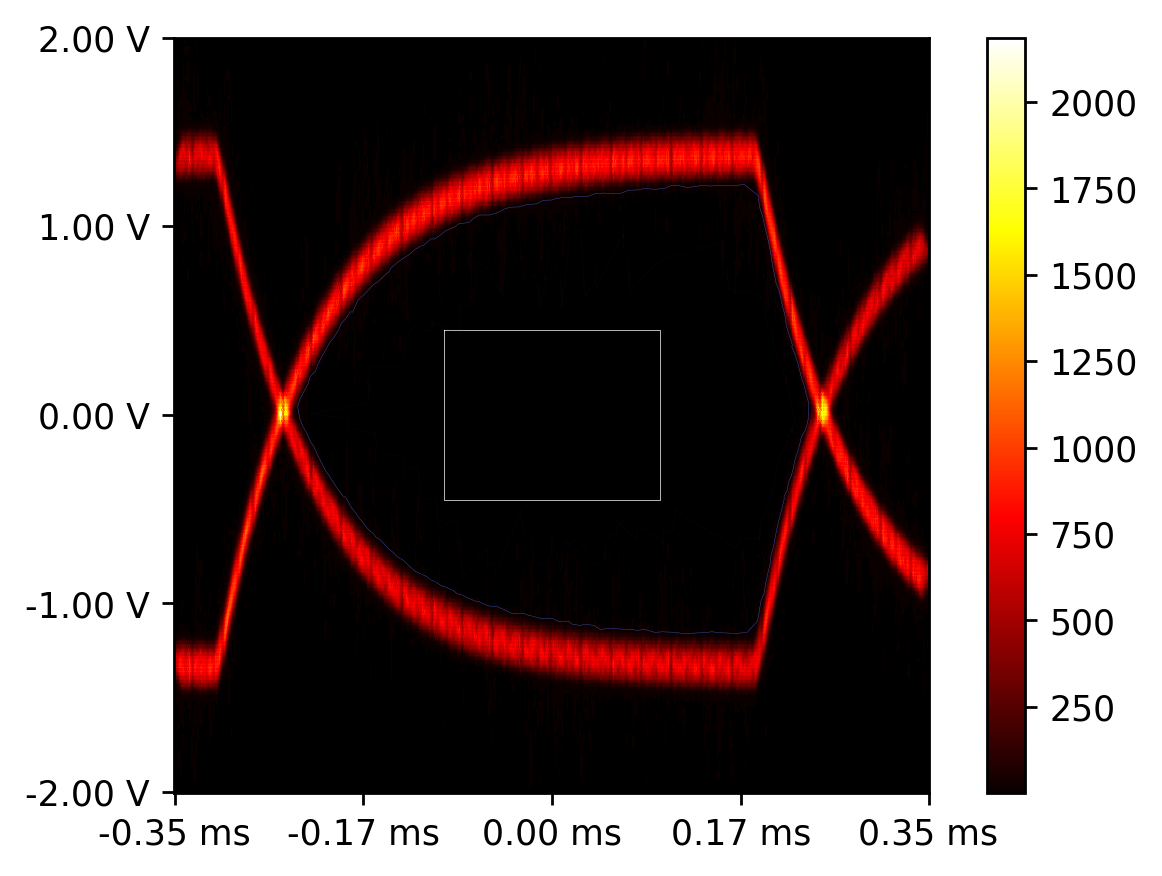

In [19]:
plt.figure(dpi=250)
grid = grid.astype(np.float32)
grid[grid==0] = np.nan
plt.imshow(grid,origin='lower',cmap=plt.cm.hot)
ax = plt.gca()
nx = grid.shape[0]
no_labels = 5# how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = list(range(0,grid_size))[::step_x] # labels you want to see
plt.xticks(np.append(x_positions,grid_size-1), [ '{:0.2f} ms'.format((x_ll/grid_size-0.5)*(tmax-tmin)*1e3) for x_ll in np.append(x_labels,grid_size) ])
ny = grid.shape[1]
no_labels = 5# how many labels to see on axis x
step_y = int(ny / (no_labels - 1)) # step between consecutive labels
y_positions = np.arange(0,ny,step_y) # pixel count at label position
y_labels = list(range(0,grid_size))[::step_y] # labels you want to see
plt.yticks(np.append(y_positions,grid_size-1), [ '{:0.2f} V'.format((y_ll/grid_size-.5)*(ymax-ymin)) for y_ll in np.append(y_labels,grid_size) ])
ax.set_facecolor('k')
plt.colorbar()


# Plot Eye Mask
eye_range_t = [-0.1e-3, 0.1e-3]
eye_range_v = [-0.45, 0.45]
x1,y1 = point_to_grid(eye_range_t[0], eye_range_v[1])
x2,y2 = point_to_grid(eye_range_t[1], eye_range_v[1])
x3,y3 = point_to_grid(eye_range_t[1], eye_range_v[0])
x4,y4 = point_to_grid(eye_range_t[0], eye_range_v[0])
x5,y5 = point_to_grid(eye_range_t[0], eye_range_v[1])
plt.plot([x1,x2,x3,x4,x5],[y1,y2,y3,y4,y5],color='w',linewidth=0.2)

# constant for genreating the contour using a polar sweep starting at the middle of the grid
num_points_contour = 200
supersample = 10

#create worst-case contour
contour_polar = np.empty((num_points_contour*supersample,2))
for n in range(num_points_contour*supersample):
    theta = n*2*np.pi/(num_points_contour*supersample)
    for r in range(0,int(grid_size*.71)):
        x_test = r*np.cos(theta)+grid_size/2
        y_test = r*np.sin(theta)+grid_size/2
        if(grid[int(y_test),int(x_test)]>0):
            contour_polar[n] = (theta,r)
            break

contour_ds_polar = np.empty((num_points_contour+1,2))
for n in range(num_points_contour):
    contour_ds_polar[n] = [contour_polar.T[0][np.argmin(contour_polar.T[1][(n*supersample):(n*supersample+supersample)])+n*supersample] , np.min(contour_polar.T[1][(n*supersample):(n*supersample+supersample)])]
contour_ds_polar[num_points_contour] = contour_ds_polar[0]
plt.plot(contour_ds_polar.T[1]*np.cos(contour_ds_polar.T[0])+grid_size/2,contour_ds_polar.T[1]*np.sin(contour_ds_polar.T[0])+grid_size/2, color='royalblue',linewidth=0.01)


#create 3 sigma contour
contour_polar = np.empty((num_points_contour*supersample,2))
for n in range(num_points_contour*supersample):
    theta = n*2*np.pi/(num_points_contour*supersample)
    sampss = 0
    for r in range(0,int(grid_size*.71)):
        x_test = r*np.cos(theta)+grid_size/2
        y_test = r*np.sin(theta)+grid_size/2
        if(grid[int(y_test),int(x_test)]>samples*(1-0.9987)):
            contour_polar[n] = (theta,r)
            break

contour_ds_polar = np.empty((num_points_contour+1,2))
for n in range(num_points_contour):
    contour_ds_polar[n] = [contour_polar.T[0][np.argmin(contour_polar.T[1][(n*supersample):(n*supersample+supersample)])+n*supersample] , np.min(contour_polar.T[1][(n*supersample):(n*supersample+supersample)])]
contour_ds_polar[num_points_contour] = contour_ds_polar[0]
plt.plot(contour_ds_polar.T[1]*np.cos(contour_ds_polar.T[0])+grid_size/2,contour_ds_polar.T[1]*np.sin(contour_ds_polar.T[0])+grid_size/2, color='royalblue',linewidth=0.1)


# save and plot
plt.savefig("eye.png", bbox_inches='tight', dpi=1000)
plt.show()